## Yelp Reviews Topic Modelling

Create topic groups by analysing positive and negative review datasets per cuisine/location combination and save to CSV file.  
Reference : *https://github.com/Vishwacorp/yelp_nlp/blob/master/2_text_processing.ipynb*

### Import Necessary Packages & Modules

In [27]:
from pprint import pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from io import BytesIO
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, HTML
from sklearn.feature_extraction import text  # Stopwords
from sklearn.feature_extraction.text import TfidfVectorizer # for TFIDF Vectoriser
from gensim import corpora, models, similarities, matutils # for LSA
from sklearn.decomposition import NMF # to run Non-negative matrix factorization 
import sklearn.metrics.pairwise as smp # to compute cosine similarities
from sklearn.feature_extraction.text import CountVectorizer 

%matplotlib inline
sns.set()

### Load Datasets 

In [4]:
## Load Business Features & Reviews

restaurants_df = pd.read_csv("datasets/odyssey_restaurants.csv") # Business Feature dataset
reviews_df = pd.read_csv("datasets/odyssey_sentiment.csv") # Review dataset


C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Run Data Manipulaltion

In [5]:
# Remove Unwanted Variable [Index]

del(restaurants_df['Unnamed: 0'])

# del(reviews_df['Unnamed: 0'])

# restaurants_df = restaurants_df[restaurants_df['RestaurantsPriceRange2'] == 2]
# reviews_df = reviews_df.loc[reviews_df['business_id'].isin(restaurants_df.business_id)]


In [6]:
# Merge Required Variables from Business_Features 

reviews_df = reviews_df.merge(restaurants_df[['business_id', 'name', 'city','latitude','longitude','cuisine']],\
                              left_on='business_id', right_on='business_id'\
                             )[['business_id', 'name', 'city','latitude','longitude','cuisine', 'stars', 'text','label']]

reviews_df= reviews_df.drop_duplicates()

In [7]:
# Check Star-ratings Types

reviews_df['stars'].unique()

# reviews_df = reviews_df[reviews_df['stars'] != 'stars']

array([1, 3, 5, 4, 2, '1', '5', '3', '4', '2'], dtype=object)

In [8]:
# Amend Star-ratings for consistency & effectiveness

reviews_df['stars'] = reviews_df['stars'].map({'5': 5, '4': 4, '3': 3, '2': 2, '1': 1, 5: 5, 4: 4, 3: 3, 2: 2, 1: 1})

reviews_df['stars'].unique()

array([1, 3, 5, 4, 2], dtype=int64)

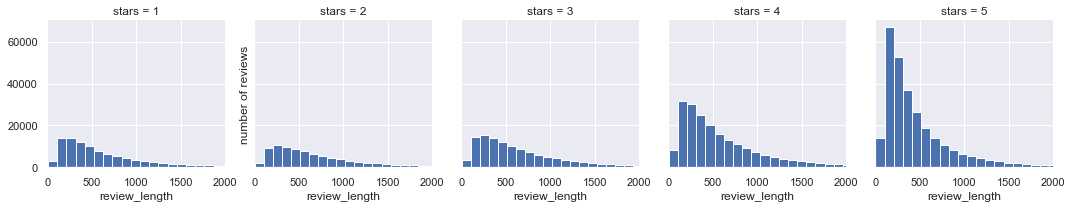

In [9]:
# Check distribution of length of Reviews

reviews_df['review_length'] = reviews_df.text.map(len)

ax = sns.FacetGrid(data=reviews_df, col='stars', xlim=(0, 2000)).map(plt.hist, 'review_length', bins=50)

ax.axes[0][1].set(ylabel='number of reviews');

We can see here that generally, the higher ratings a reviews received, the longer the  review is.

### Run for specific City+Cuisine (to have different list of Topics per combination)

In [10]:
# Split positive & negative reviews according to results of Sentiment Analysis

pos_reviews = reviews_df.text[(reviews_df.city == 'Toronto') & (reviews_df.cuisine == 'american') &\
                              (reviews_df.label == 1)].values # change city name and cuisine type

neg_reviews = reviews_df.text[(reviews_df.city == 'Toronto') & (reviews_df.cuisine == 'american') &\
                              (reviews_df.label == -1)].values # change city name and cuisine type

print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  26,480
Negative Reviews:  5,134


### Proceed with analysing texts

In [60]:
# Add additional stopwords 

extrawords = ['ve', 'like', 'got', 'american','toronto','just', 
               'don', 'really', 'said', 'told', 'ok',
               'came', 'went', 'did', 'didn', 'good', 'kim', 'pho']
stopwords = text.ENGLISH_STOP_WORDS.union(extra_words)

### TFIDF Vectoriser

In [29]:
# Run TFIDF Vectoriser

# Create vectoriser objects to get counts of term document
pos_tfidf = TfidfVectorizer(stop_words=stopwords, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

neg_tfidf = TfidfVectorizer(stop_words=stopwords, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews

np.random.seed(23)
num_reviews = 17500
pos_random = np.random.choice(pos_reviews, size=num_reviews)
neg_random = np.random.choice(neg_reviews, size=num_reviews)


dictionary = {'pizzas':'pizza', 'burgers':'burger', 'ordered':'order',
         'prices':'price', 'topping':'toppings', 'noodle':'noodles', 'dumpling':'dumplings'}

def replace_words(text, dictionary):
    for i,j in dictionary.items():
        text = text.replace(i,j)
    return text # Returns text with word substitutions made according to the passed dictionary.

pos_random = [replace_words(w, dictionary) for w in pos_random]
neg_random = [replace_words(w, dictionary) for w in neg_random]

# Obtain the vectors by fitting the vocabulary.
pos_vectors = pos_tfidf.fit_transform(pos_random)
neg_vectors = neg_tfidf.fit_transform(neg_random)


In [30]:
# Store TFIDF vectors in a Pandas DF for further analysis

pos_df = pd.DataFrame(pos_vectors.todense(), columns=[pos_tfidf.get_feature_names()])
neg_df = pd.DataFrame(neg_vectors.todense(), columns=[neg_tfidf.get_feature_names()])

# get mean for each column (word): highest means are most important words

col_means_neg = {}
for col in neg_df:
    col_means_neg[col] = neg_df[col].mean()

col_means_pos = {}
for col in pos_df:
    col_means_pos[col] = pos_df[col].mean()
    
num_top_words = 10

# Print Top Words for Positive & Negative Reviews

print('Top %d words in Positive reviews:' %num_top_words, end='')
print(sorted(col_means_pos, key=col_means_pos.get, reverse=True)[:num_top_words])

print('Top %d words in Negative reviews:' %num_top_words, end='')
print(sorted(col_means_neg, key=col_means_neg.get, reverse=True)[:num_top_words])

Top 10 words in Positive reviews:[('great',), ('place',), ('service',), ('order',), ('chicken',), ('time',), ('nice',), ('burger',), ('menu',), ('restaurant',)]
Top 10 words in Negative reviews:[('service',), ('place',), ('order',), ('time',), ('restaurant',), ('chicken',), ('burger',), ('bad',), ('server',), ('table',)]


Analysis on TFIDF:

i. Top 10 words for positive & negative reviews revolve around general atmosphere or/and service.

ii. Some differences between the tow categories (pos/neg) are mainly on adjective i.e. nice,great,bad.

iii. Hence, analysis on topics found in reviews need to proceed further than just the top words, and analyse other words that possibly group together within the same descriptions.

In [31]:
# Remove DataFrames to save memory
del pos_df
del neg_df

### Latent Semantic Analysis (LSA)

In [32]:
# Prepare for Latent Semantic Analysis (LSA)

# Convert sparse matrix (of counts) to a gensim corpus
# Genism requires terms by docs hence, transpose the matrix 

pos_corpus = matutils.Sparse2Corpus(pos_vectors.transpose())
neg_corpus = matutils.Sparse2Corpus(neg_vectors.transpose())

# Row indices
pos_id2word = dict((v,k) for k,v in pos_tfidf.vocabulary_.items())
neg_id2word = dict((v,k) for k,v in neg_tfidf.vocabulary_.items())

# Run corpora (for Python 3 only)
id2word_pos = corpora.Dictionary.from_corpus(pos_corpus, id2word=pos_id2word)
id2word_neg = corpora.Dictionary.from_corpus(neg_corpus, id2word=neg_id2word)

In [33]:
# Create the LSA model
num_of_topics = 7
lsa_pos = models.LsiModel(pos_corpus, id2word=id2word_pos, num_topics=num_of_topics)
lsa_neg = models.LsiModel(neg_corpus, id2word=id2word_neg, num_topics=num_of_topics)

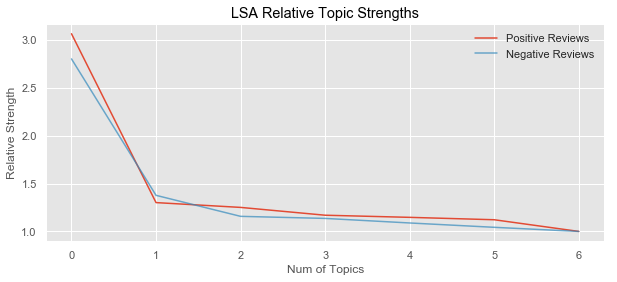

In [34]:
# Plot the LSA Relative Topic Strength

pos_singular_values = lsa_pos.projection.s.tolist()
pos_rel = [sv/pos_singular_values[-1] for sv in pos_singular_values]
neg_singular_values = lsa_neg.projection.s.tolist()
neg_rel = [sv/neg_singular_values[-1] for sv in neg_singular_values]

plt.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.plot(range(len(pos_singular_values)), pos_rel, label='Positive Reviews', alpha=1.0)
plt.plot(range(len(neg_singular_values)), neg_rel, label='Negative Reviews', alpha=0.7)
plt.xticks(range(len(pos_singular_values)), range(len(pos_singular_values)))
plt.xlabel('Num of Topics')
plt.ylabel('Relative Strength')
plt.title('LSA Relative Topic Strengths', color = 'black')
plt.legend(framealpha = 0, loc = 'best');

The LSA relative plot above shows that the 1st topic is about 2.5 times stronger than rest of the topics i.e.concept of diminishing returns can be observed. 

For further analyses, we shall choose top 5 or 6 topics

In [35]:
topics = 5

In [36]:
# Review top Positive Topics
print('Top %d Topics on Positive reviews' %(topics))
print('-'*50)
pprint(lsa_pos.show_topics()[0:topics])

Top 5 Topics on Positive reviews
--------------------------------------------------
[(0,
  '0.212*"great" + 0.199*"place" + 0.161*"service" + 0.151*"order" + '
  '0.133*"chicken" + 0.128*"time" + 0.125*"burger" + 0.123*"nice" + '
  '0.119*"menu" + 0.117*"restaurant"'),
 (1,
  '0.459*"great" + -0.313*"chicken" + -0.228*"burger" + 0.221*"place" + '
  '0.169*"service" + -0.158*"fried" + -0.158*"order" + -0.156*"fries" + '
  '0.142*"drinks" + 0.136*"atmosphere"'),
 (2,
  '-0.691*"burger" + -0.237*"fries" + -0.167*"wings" + -0.150*"place" + '
  '-0.134*"great" + -0.133*"beer" + 0.121*"restaurant" + 0.111*"dessert" + '
  '0.110*"brunch" + 0.097*"dish"'),
 (3,
  '-0.386*"brunch" + -0.329*"chicken" + 0.231*"burger" + -0.211*"eggs" + '
  '-0.203*"breakfast" + -0.197*"pancakes" + -0.162*"waffles" + -0.152*"fried" '
  '+ -0.135*"great" + 0.127*"restaurant"'),
 (4,
  '0.428*"burger" + -0.414*"wings" + -0.323*"chicken" + 0.292*"brunch" + '
  '0.186*"eggs" + 0.169*"breakfast" + 0.166*"pancakes" + -0

In [37]:
# Review top Negative Topics
print('Top %d Topics on Negative reviews' %(topics))
print('-'*50)
pprint(lsa_neg.show_topics()[0:topics])

Top 5 Topics on Negative reviews
--------------------------------------------------
[(0,
  '0.226*"service" + 0.202*"order" + 0.191*"place" + 0.164*"time" + '
  '0.132*"restaurant" + 0.129*"minutes" + 0.129*"server" + 0.128*"table" + '
  '0.121*"chicken" + 0.118*"bad"'),
 (1,
  '0.434*"burger" + 0.296*"chicken" + 0.237*"fries" + -0.212*"minutes" + '
  '-0.188*"table" + -0.133*"service" + 0.132*"dry" + 0.119*"sandwich" + '
  '-0.118*"wait" + -0.117*"server"'),
 (2,
  '-0.439*"burger" + 0.314*"place" + -0.254*"minutes" + -0.217*"order" + '
  '0.179*"bar" + -0.155*"took" + 0.141*"great" + -0.135*"table" + '
  '-0.135*"fries" + -0.121*"waited"'),
 (3,
  '-0.601*"burger" + 0.478*"chicken" + 0.195*"wings" + -0.189*"place" + '
  '-0.157*"bar" + 0.155*"order" + 0.117*"sandwich" + 0.102*"waffles" + '
  '-0.101*"beer" + -0.083*"drinks"'),
 (4,
  '-0.560*"wings" + -0.270*"bar" + -0.202*"beer" + 0.202*"service" + '
  '0.152*"eggs" + 0.134*"restaurant" + -0.132*"chicken" + 0.128*"brunch" + '
  '0.1

In [38]:
# Transform Negative values from LSA Outputs, using Non-negative matrix factorization (NMF)

# Change number of topics:
num_of_topics = 6

# Run NMF
pos_nmf = NMF(n_components=num_of_topics)
pos_w = pos_nmf.fit_transform(pos_vectors)
pos_h = pos_nmf.components_

neg_nmf = NMF(n_components=num_of_topics)
neg_w = neg_nmf.fit_transform(neg_vectors)
neg_h = neg_nmf.components_

In [39]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

num_topics = num_of_topics
num_top_words = 7

print('Top topics + words for Positive reviews')
print('-'*100)
display_topics(pos_nmf, pos_tfidf.get_feature_names(), num_topics, num_top_words)

print('')
print('')

print('Top topics + words for Negative reviews')
print('-'*100)
display_topics(neg_nmf, neg_tfidf.get_feature_names(), num_topics, num_top_words)

Top topics + words for Positive reviews
----------------------------------------------------------------------------------------------------
Topic 0:   1.691*place, 1.139*bar, 0.919*beer, 0.869*drinks, 0.765*wings, 0.582*nice, 0.569*night
Topic 1:   2.309*great, 0.841*service, 0.561*atmosphere, 0.538*staff, 0.535*amazing, 0.509*friendly, 0.316*place
Topic 2:   2.764*burger, 0.787*fries, 0.281*onion, 0.278*rings, 0.240*patty, 0.214*bun, 0.210*order
Topic 3:   1.616*brunch, 0.964*eggs, 0.891*breakfast, 0.858*pancakes, 0.571*wait, 0.520*toast, 0.467*coffee
Topic 4:   1.846*chicken, 0.823*fried, 0.600*ribs, 0.505*sandwich, 0.496*pork, 0.486*sauce, 0.441*bbq
Topic 5:   0.796*restaurant, 0.784*order, 0.622*menu, 0.557*meal, 0.536*dessert, 0.517*experience, 0.470*table


Top topics + words for Negative reviews
----------------------------------------------------------------------------------------------------
Topic 0:   2.038*place, 1.123*bar, 0.713*beer, 0.572*drinks, 0.501*people, 0.464*nig

### Have a look at Similarities of Reviews using NMF

In [40]:
# Select a Random Positive Review

review_num = np.random.randint(0, high=len(pos_random))
print(review_num)
print(pos_random[review_num])

1635
I went to Canoe on Sunday for their Summerlicious promotion and it was AMAZING! The menu was definitely a "best of Canoe" menu which isn't usually the case for restaurants with Summerlicious promotions. I had the spinach salad followed by the Alberta beef sirloin and the chocolate ganache for dessert. My date had the lamb as an entree which was equally amazing! This place lives up to the hype and is definitely worth the price. Amazing service, ambiance (the view!) and food and will definitely be going back!


In [41]:
# Compute cosine similarities (smp) of review with all other reviews in the new space

cosine = {}
for ind, review in enumerate(pos_w):
    similarity = smp.cosine_similarity(pos_w[review_num].reshape(1,-1), review.reshape(1,-1))
    cosine[ind] = similarity[0][0]

In [42]:
# Generate top 3 similar reviews

for n in sorted(cosine, key=cosine.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosine[n]))
    print(pos_random[n])
print('-'*50)

--------------------------------------------------
>> Similarity 1.000






Well done Ruby. P.S. The name of the restaurant is based on a sign they found and just put it on the wall. lol
--------------------------------------------------
>> Similarity 0.999




I'll definitely go back.
--------------------------------------------------
>> Similarity 0.999
Enjoyed their delicious wild salmon with orzo followed by a wonderful lime tart Brule with sour cream ice cream. And I had a vodka iced tea with ginger.... that was the best meal ever!  All while waiting for a TIFF Movie. Great way to enjoy the festival!
--------------------------------------------------


### Count Vectoriser

In [43]:
# Create count vectoriser objects to generate counts of term document.

pos_cvect = CountVectorizer(stop_words=stopwords, min_df=10, max_df=0.5,ngram_range=(1,1), token_pattern='[a-z][a-z]+')

neg_cvect = CountVectorizer(stop_words=stopwords, min_df=10, max_df=0.5,ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 10000
random_pos_cvect = np.random.choice(pos_reviews, size=num_reviews)
random_neg_cvect = np.random.choice(neg_reviews, size=num_reviews)

# Change words from the defined 'dictionary' ran above.
random_pos_cvect = [replace_words(w, dictionary) for w in random_pos_cvect]
random_neg_cvect = [replace_words(w, dictionary) for w in random_neg_cvect]

# Obtain the Vectors of the Cvects
pos_cv_vectors = pos_cvect.fit_transform(random_pos_cvect).transpose()
neg_cv_vectors = neg_cvect.fit_transform(random_neg_cvect).transpose()

In [44]:
# Convert sparse matrix (of counts) to a gensim corpus
pos_corpus = matutils.Sparse2Corpus(pos_cv_vectors)
neg_corpus = matutils.Sparse2Corpus(neg_cv_vectors)

# Save the mapping (dict) of row id to word (token) to be used later by Gensim 
pos_cvect_id2word = dict((v, k) for k, v in pos_cvect.vocabulary_.items())
neg_cvect_id2word = dict((v, k) for k, v in neg_cvect.vocabulary_.items())

### Latent Dirichlet Allocation (LDA)

In [45]:
# Create LDA Models
num_of_topics = 5
pos_lda = models.ldamulticore.LdaMulticore(corpus=pos_corpus, num_topics=num_of_topics, 
                                           id2word=pos_cvect_id2word, passes=10, workers=15)
neg_lda = models.ldamulticore.LdaMulticore(corpus=neg_corpus, num_topics=num_of_topics, 
                                           id2word=neg_cvect_id2word, passes=10, workers=15)

In [47]:
num_top_words = 7

print('Top topics + words for Positive reviews')
print('-'*100)
pprint(pos_lda.print_topics(num_words=num_top_words))

print('')
print('')

print('Top topics + words for Negative reviews')
print('-'*100)
pprint(neg_lda.print_topics(num_words=num_top_words))

Top topics + words for Positive reviews
----------------------------------------------------------------------------------------------------
[(0,
  '0.013*"place" + 0.011*"great" + 0.011*"service" + 0.009*"chicken" + '
  '0.008*"time" + 0.008*"order" + 0.008*"cheese"'),
 (1,
  '0.010*"order" + 0.008*"great" + 0.007*"menu" + 0.007*"dish" + '
  '0.007*"brunch" + 0.006*"dessert" + 0.006*"delicious"'),
 (2,
  '0.022*"place" + 0.021*"great" + 0.012*"service" + 0.010*"bar" + '
  '0.007*"drinks" + 0.007*"nice" + 0.007*"beer"'),
 (3,
  '0.012*"order" + 0.010*"time" + 0.010*"restaurant" + 0.010*"service" + '
  '0.009*"table" + 0.007*"menu" + 0.006*"place"'),
 (4,
  '0.016*"burger" + 0.014*"chicken" + 0.012*"fries" + 0.012*"place" + '
  '0.011*"order" + 0.009*"great" + 0.008*"sauce"')]


Top topics + words for Negative reviews
----------------------------------------------------------------------------------------------------
[(0,
  '0.021*"order" + 0.017*"service" + 0.008*"menu" + 0.008*"server

## Continuing with NMF

In [53]:
# Recall the topics for Positive Reviews

print('Top topics + words for Positive reviews')
print('-'*100)
display_topics(pos_nmf, pos_tfidf.get_feature_names(), num_of_topics, num_top_words)

Top topics + words for Positive reviews
----------------------------------------------------------------------------------------------------
Topic 0:   1.691*place, 1.139*bar, 0.919*beer, 0.869*drinks, 0.765*wings, 0.582*nice, 0.569*night
Topic 1:   2.309*great, 0.841*service, 0.561*atmosphere, 0.538*staff, 0.535*amazing, 0.509*friendly, 0.316*place
Topic 2:   2.764*burger, 0.787*fries, 0.281*onion, 0.278*rings, 0.240*patty, 0.214*bun, 0.210*order
Topic 3:   1.616*brunch, 0.964*eggs, 0.891*breakfast, 0.858*pancakes, 0.571*wait, 0.520*toast, 0.467*coffee
Topic 4:   1.846*chicken, 0.823*fried, 0.600*ribs, 0.505*sandwich, 0.496*pork, 0.486*sauce, 0.441*bbq


In [55]:
# Recall the topics for Negative Reviews

print('Top topics + words for Negative reviews')
print('-'*100)
display_topics(neg_nmf, neg_tfidf.get_feature_names(), num_of_topics, num_top_words)

Top topics + words for Negative reviews
----------------------------------------------------------------------------------------------------
Topic 0:   2.038*place, 1.123*bar, 0.713*beer, 0.572*drinks, 0.501*people, 0.464*night, 0.416*patio
Topic 1:   1.805*chicken, 0.710*sandwich, 0.687*order, 0.679*salad, 0.591*fries, 0.472*dry, 0.462*cheese
Topic 2:   1.209*minutes, 1.106*table, 0.979*order, 0.842*server, 0.777*time, 0.760*wait, 0.758*asked
Topic 3:   2.860*burger, 0.709*fries, 0.281*bun, 0.281*patty, 0.270*onion, 0.267*cheese, 0.233*rings
Topic 4:   2.430*wings, 0.324*sauce, 0.232*order, 0.219*wing, 0.213*beer, 0.210*louis, 0.199*ribs


In [54]:
# Have a look at a random positive review and see the distribution across top topics\

review_num = np.random.randint(0, high=len(pos_random))
print('Positive Review #%d' %review_num)
print('-'*100)
print(pos_random[review_num])
print('-'*100)
topic_dict = {}
for ind, w in enumerate(pos_w[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Positive Review #14516
----------------------------------------------------------------------------------------------------
Have been to Ronnie B's twice in the last week and enjoyed the food, atmosphere and service thoroughly.  Try the grilled cheese made with raisin bread - excellent.  Shrimp etouffee very tasty and the bread pudding is rich and sweet and just the right amount to share.
----------------------------------------------------------------------------------------------------
Topic 5: 0.0380
Topic 1: 0.0205
Topic 4: 0.0094
Topic 2: 0.0036
Topic 0: 0.0000
Topic 3: 0.0000


In [58]:
# Have a look at a random negative review and see the distribution across top topics

review_num = np.random.randint(0, high=len(neg_random))
print('Negative Review #%d' %review_num)
print('-'*100)
print(neg_random[review_num])
print('-'*100)
topic_dict = {}
for ind, w in enumerate(neg_w[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negative Review #3563
----------------------------------------------------------------------------------------------------
Actually the worst bar and  management in Toronto. The bouncers let a group of black out girls, by pass the line, who were slurring their words and puking in the alley way. And when I commented, a bouncer told me to "shut the Fuck up. Quit my bitching, or leave.". Once inside, the line for a drink was ridiculous and the cup they gave me had lipstick all over it. When I asked for a new cup the bartender rolled her eyes, waved over a bouncer and told him I was cut off. GREAT PLACE. hope it gets shut down.
----------------------------------------------------------------------------------------------------
Topic 0: 0.0349
Topic 2: 0.0129
Topic 5: 0.0001
Topic 1: 0.0000
Topic 3: 0.0000
Topic 4: 0.0000


### Run Topic Modeling for All Reviews in Particular City+Cuisine

By now, the topics found are generally interpretable and can be seen matching with the reviews that the topics are trying to group/categorise.

Next, we proceed with topic modeling on all reviews and businesses (selected city+cuisine) using NMF.

In [59]:
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  26,480
Negative Reviews:  5,134


In [62]:
# Create count vectoriser objects to generate counts of term document.

pos_tfidf = TfidfVectorizer(stop_words=stopwords, min_df=10, max_df=0.5,ngram_range=(1,1), token_pattern='[a-z][a-z]+')

neg_tfidf = TfidfVectorizer(stop_words=stopwords, min_df=10, max_df=0.5,ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Change words from the defined 'dictionary' ran above.
pos_reviews = [replace_words(w, dictionary) for w in pos_reviews]
neg_reviews = [replace_words(w, dictionary) for w in neg_reviews]

# Get the vectors
pos_vectors = pos_tfidf.fit_transform(pos_reviews)
neg_vectors = neg_tfidf.fit_transform(neg_reviews)

In [63]:
## Run NMF

# change num_topics
num_of_topics = 6

pos_nmf = NMF(n_components=num_of_topics)
pos_w = pos_nmf.fit_transform(pos_vectors)
pos_h = pos_nmf.components_

neg_nmf = NMF(n_components=num_topics)
neg_w = neg_nmf.fit_transform(neg_vectors)
neg_h = neg_nmf.components_

In [65]:
no_topics = num_of_topics
no_top_words = 10

print('Topics for Positive reviews')
print('-'*100)
display_topics(pos_nmf, pos_tfidf.get_feature_names(), no_topics, no_top_words)

print('\nTopics for Negative reviews')
print('-'*100)
display_topics(neg_nmf, neg_tfidf.get_feature_names(), no_topics, no_top_words)

Topics for Positive reviews
----------------------------------------------------------------------------------------------------
Topic 0:   1.732*place, 1.319*bar, 1.166*beer, 0.942*drinks, 0.895*wings, 0.652*night, 0.636*pretty, 0.619*nice, 0.610*patio, 0.579*drink
Topic 1:   2.510*great, 0.900*service, 0.654*atmosphere, 0.613*amazing, 0.610*staff, 0.572*friendly, 0.373*definitely, 0.367*place, 0.363*recommend, 0.350*excellent
Topic 2:   3.279*burger, 0.910*fries, 0.326*rings, 0.309*onion, 0.280*patty, 0.269*cheese, 0.262*bun, 0.220*order, 0.191*beef, 0.174*potato
Topic 3:   2.569*chicken, 1.076*fried, 0.729*ribs, 0.662*sandwich, 0.647*sauce, 0.621*fries, 0.611*pork, 0.601*waffles, 0.530*bbq, 0.463*brisket
Topic 4:   1.942*brunch, 1.066*eggs, 0.984*breakfast, 0.932*pancakes, 0.673*wait, 0.598*toast, 0.511*coffee, 0.462*bacon, 0.445*french, 0.374*benedict
Topic 5:   0.831*order, 0.823*restaurant, 0.670*menu, 0.568*meal, 0.564*dessert, 0.549*experience, 0.514*time, 0.503*salad, 0.498*ta

### Only Run The Lines Applicable To This Run's Combination of City + Cuisine

In [610]:
# TORONTO AMERICAN TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Bar/Beer', 1:'Customer Service/Atmosphere', 2:'Burger/Fries', 
              3:'Chicken/Ribs/Sandwich', 4:'Brunch/Eggs', 5:'Order/Waiting Time'}

neg_topics = {0:'Waiting Time', 1:'Chicken/Sandwich', 2:'Beer/Bar/Drinks', 
              3:'BUrger/Fries', 4:'Wings/Sauce', 5:'Customer Service'}

t_amer_pos_topics = pos_topics
t_amer_neg_topics = neg_topics

In [530]:
# CALGARY CHINESE TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Soup/Pork', 1:'Dim Sum', 2:'Customer Service', 
              3:'Ginger Beef/Chicken', 4:'Pad Thai/Curry', 5:'Bubble Tea'}

neg_topics = {0:'Buffet/Atmosphere', 1:'Chicken/Soup', 2:'Dim Sum', 
              3:'Order/Waiting Time', 4:'Ginger Beef/Pork', 5:'Customer Service'}

c_chi_pos_topics = pos_topics
c_chi_neg_topics = neg_topics

In [476]:
# TORONTO ITALIAN TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Order/Waiting Time', 1:'Pizza', 2:'Customer Service', 
              3:'Pasta', 4:'Atmosphere'}

neg_topics = {0:'Customer Service', 1:'Pizza', 2:'Pasta', 
              3:'Order/Waiting Time', 4:'Atmosphere'}

t_ita_pos_topics = pos_topics
t_ita_neg_topics = neg_topics

In [363]:
# TORONTO CHINESE TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Waiting Time', 1:'Dim Sum', 2:'Dumplings', 
              3:'Noodles/Soup', 4:'Chicken Rice', 5:'Customer Service'}

neg_topics = {0:'Waiting Time', 1:'Dim Sum', 2:'Customer Service', 
              3:'Dumplings', 4:'Chicken Rice', 5:'Noodles/Soup'}

t_chi_pos_topics = pos_topics
t_chi_neg_topics = neg_topics

In [295]:
# LAS VEGAS CHINESE TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Chicken Rice/Shrimp', 1:'Dim Sum', 2:'Customer Service', 
              3:'Noodles/Soup', 4:'Waiting Time', 5:'Pad Thai/Curry'}

neg_topics = {0:'Price', 1:'Chicken Rice', 2:'Dim Sum', 
              3:'Waiting Time', 4:'Soup/Noodle', 5:'Customer Service'}

v_chi_pos_topics = pos_topics
v_chi_neg_topics = neg_topics

In [129]:
# LAS VEGAS AMERICAN TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Waiting Time', 1:'Burger/Fries/Shake', 2:'Customer Service', 
              3:'Breakfast/Eggs/Pancakes', 4:'Chicken/Waffles', 5:'Atmosphere'}

neg_topics = {0:'Atmosphere', 1:'Burger/Fries', 2:'Waiting Time', 
              3:'Chicken/Steak', 4:'Customer Service', 5:'Buffet/Price'}

v_amer_pos_topics = pos_topics
v_amer_neg_topics = neg_topics

In [130]:
# LAS VEGAS ITALIAN TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Waiting Time', 1:'Pizza', 2:'Price', 
              3:'Pasta/Chicken', 4:'Customer Service', 5:'Atmosphere'}

neg_topics = {0:'Waiting Time', 1:'Pizza', 2:'Delivery/Reservation', 
              3:'Chicken/Pasta', 4:'Customer Service', 5:'Atmosphere'}

v_ita_pos_topics = pos_topics
v_ita_neg_topics = neg_topics

In [ ]:
# CALGARY ITALIAN TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'', 1:'', 2:'', 
              3:'', 4:'', 5:''}

neg_topics = {0:'', 1:'', 2:'', 
              3:'', 4:'', 5:''}

c_ita_pos_topics = pos_topics
c_ita_neg_topics = neg_topics

In [ ]:
# CALGARY AMERICAN TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'', 1:'', 2:'', 
              3:'', 4:'', 5:''}

neg_topics = {0:'', 1:'', 2:'', 
              3:'', 4:'', 5:''}

c_amer_pos_topics = pos_topics
c_amer_neg_topics = neg_topics

## Adding Topic Weights to Pandas DataFrame

In [533]:
# Create DFs for positive & negative reviews to be used for adding topic names

pos_df = reviews_df[['business_id', 'stars', 'text', 'review_length']][(reviews_df.city == 'Calgary')\
                                                                       & (reviews_df.cuisine == 'italian') &\
                                                                       (reviews_df.label == 1)].reset_index()
neg_df = reviews_df[['business_id', 'stars', 'text', 'review_length']][(reviews_df.city == 'Calgary')\
                                                                       & (reviews_df.cuisine == 'italian') &\
                                                                       (reviews_df.label == -1)].reset_index()
pos_df.drop(labels='index', axis=1, inplace=True)
neg_df.drop(labels='index', axis=1, inplace=True)

In [536]:
# Normalise topic weights on each positive & negative reviews
pos_df = pd.concat([pos_df, pd.DataFrame(normalize(pos_w, norm='l1'))], axis=1)
neg_df = pd.concat([neg_df, pd.DataFrame(normalize(neg_w, norm='l1'))], axis=1)

In [537]:
# Check dataframes produced on line above

neg_df.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,QiRWdm4GkmtEMO_npOyBjA,2,"We went on Boxing Day, they were busy and the ...",437,0.196476,0.046365,0.058278,0.088875,0.000000,0.610006
1,jg37O7ANF7hqggS6bxUpcQ,1,Bland soup and terrible service. I don't know ...,131,0.288655,0.219540,0.000000,0.000000,0.000000,0.491805
2,jg37O7ANF7hqggS6bxUpcQ,2,"Terrible service , the servers were not friend...",288,0.000000,0.167955,0.000000,0.266047,0.339004,0.226993
3,jg37O7ANF7hqggS6bxUpcQ,2,This place is not as good as other viet restau...,110,0.939952,0.000000,0.000000,0.000000,0.000000,0.060048
4,jg37O7ANF7hqggS6bxUpcQ,5,"Savory Pho with Chicken, so good!!!!",36,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


In [538]:
# Group by business_id and apply mean/count functions to necessary columns

pos_grp_df = pos_df.groupby('business_id').agg({'stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean',5:'mean'}).reset_index()
neg_grp_df = neg_df.groupby('business_id').agg({'stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean',5:'mean'}).reset_index()

In [539]:
pos_grp_df.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,-r8SvItXXG6_T3mP5GXRAw,4.625000,8,712.875000,0.191907,0.017617,0.478255,0.162229,0.069903,0.080089
1,0gVPTer9PnXRmSjuHt-XgQ,3.888889,9,944.222222,0.187242,0.007360,0.166207,0.594204,0.030508,0.014479
2,1jxxXQYOdP91LkF2Mz9Q9Q,4.000000,4,423.500000,0.265271,0.000000,0.052772,0.272512,0.079026,0.330420
3,1oJG7PcNNNfazaSLOxwmmQ,4.500000,2,404.500000,0.410481,0.000000,0.228052,0.253979,0.107488,0.000000
4,2-l_q7HBRak5i6X46l0OHw,3.388889,18,976.722222,0.137392,0.016383,0.195692,0.018200,0.038069,0.594265


In [540]:
neg_grp_df.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,0gVPTer9PnXRmSjuHt-XgQ,2.000000,1,704.000000,0.384271,0.177961,0.021335,0.021309,0.395124,0.000000
1,1jxxXQYOdP91LkF2Mz9Q9Q,1.000000,3,248.000000,0.275628,0.040522,0.000771,0.507829,0.080587,0.094664
2,2-l_q7HBRak5i6X46l0OHw,2.000000,3,424.000000,0.189803,0.000000,0.002240,0.571950,0.005816,0.230191
3,21aDJ_xLGcEDkcyQRexlOQ,1.833333,6,491.166667,0.198490,0.076140,0.034792,0.313335,0.322016,0.055227
4,2M3tt_0FfsDiy-DDWIH4dg,1.000000,1,197.000000,0.061496,0.000000,0.124043,0.673644,0.037946,0.102871


## Adding in Business Information 

In [542]:
# merge business name/city with topic data
pos_df_tot = pos_grp_df.merge(restaurants_df
                              [['business_id', 'name', 'city','neighborhood','latitude',
                                'longitude','cuisine','RestaurantsPriceRange2']],
                              left_on='business_id',right_on='business_id'
                             )[['business_id', 'name', 'city','neighborhood','latitude',
                                'longitude','cuisine','RestaurantsPriceRange2', 'stars', 0, 1, 2, 3, 4,5]]

neg_df_tot = neg_grp_df.merge(restaurants_df
                              [['business_id', 'name', 'city','neighborhood','latitude',
                                'longitude','cuisine','RestaurantsPriceRange2']], 
                              left_on='business_id',right_on='business_id'
                             )[['business_id', 'name', 'city','neighborhood','latitude',
                                'longitude','cuisine','RestaurantsPriceRange2', 'stars', 0, 1, 2, 3, 4,5]]

In [543]:
# Check 1 business output for Positive Topic

pos_grp_df[pos_grp_df.business_id == 'jg37O7ANF7hqggS6bxUpcQ']

,business_id,stars,text,review_length,0,1,2,3,4,5
156,jg37O7ANF7hqggS6bxUpcQ,3.861111,36,622.833333,0.197244,0.020252,0.490782,0.107854,0.098136,0.085733


In [544]:
# Check 1 business output for Negative Topic

neg_grp_df[neg_grp_df.business_id == 'jg37O7ANF7hqggS6bxUpcQ']

,business_id,stars,text,review_length,0,1,2,3,4,5
134,jg37O7ANF7hqggS6bxUpcQ,3.0,5,130.2,0.337006,0.304949,0.026292,0.055292,0.067801,0.20866


In [376]:
pos_df_tot = pos_df_tot.drop_duplicates()
neg_df_tot = neg_df_tot.drop_duplicates()

In [545]:
# Check final output:

pos_df_tot[pos_df_tot.business_id == 'jg37O7ANF7hqggS6bxUpcQ']

,business_id,name,city,neighborhood,latitude,longitude,cuisine,RestaurantsPriceRange2,stars,0,1,2,3,4,5
157,jg37O7ANF7hqggS6bxUpcQ,Pho Thanh Vietnamese Noodle House & Restaurant,Calgary,NaN,51.11154,-114.055896,chinese,1.0,3.861111,0.197244,0.020252,0.490782,0.107854,0.098136,0.085733


In [137]:
# v_amer_pos = df_pos_tot.rename(columns={'0': 'Waiting Time', '1': 'Burger/Fries/Shake', '2': 'Customer Service', '3': 'Breakfast/Eggs/Pancakes',\
#                                         '4': 'Chicken/Waffles', '5': 'Atmosphere'})

# v_amer_neg = df_neg_tot.rename(columns={'0': 'Atmosphere', '1': 'Burger/Fries', '2': 'Waiting Time', '3': 'Chicken/Steak',\
#                                        '4': 'Customer Service', '5': 'Buffet/Price'})

In [219]:
# v_ita_pos = df_pos_tot.rename(columns={0:'Waiting Time', 1:'Pizza', 2:'Price',\
#                                        3:'Pasta/Chicken', 4:'Customer Service', 5:'Atmosphere'})

# v_ita_neg = df_neg_tot.rename(columns={0:'Waiting Time', 1:'Pizza', 2:'Delivery/Reservation',\
#                                        3:'Chicken/Pasta', 4:'Customer Service', 5:'Atmosphere'})

In [327]:
v_chi_pos = df_pos_tot.rename(columns={0:'Chicken Rice/Shrimp', 1:'Dim Sum', 2:'Customer Service',\
                                       3:'Noodles/Soup', 4:'Waiting Time', 5:'Pad Thai/Curry'})

v_chi_neg = df_neg_tot.rename(columns={0:'Price', 1:'Chicken Rice', 2:'Dim Sum', \
                                       3:'Waiting Time', 4:'Soup/Noodle', 5:'Customer Service'})

In [379]:
t_chi_pos = df_pos_tot.rename(columns={0:'Waiting Time', 1:'Dim Sum', 2:'Dumplings',\
                                       3:'Noodles/Soup', 4:'Chicken Rice', 5:'Customer Service'})

t_chi_neg = df_neg_tot.rename(columns={0:'Waiting Time', 1:'Dim Sum', 2:'Customer Service',\
                                       3:'Dumplings', 4:'Chicken Rice', 5:'Noodles/Soup'})

In [431]:
t_amer_pos = df_pos_tot.rename(columns={0:'Bar/Beer', 1:'Customer Service/Atmosphere', 2:'Burger/Fries',\
                                        3:'Chicken/Ribs/Sandwich', 4:'Brunch/Eggs', 5:'Order/Waiting Time'})

t_amer_neg = df_neg_tot.rename(columns={0:'Waiting Time', 1:'Chicken/Sandwich', 2:'Beer/Bar/Drinks',\
                                        3:'BUrger/Fries', 4:'Wings/Sauce', 5:'Customer Service'})

In [493]:
t_ita_pos = df_pos_tot.rename(columns={0:'Order/Waiting Time', 1:'Pizza', 2:'Customer Service',\
                                       3:'Pasta', 4:'Atmosphere'})

t_ita_neg = df_neg_tot.rename(columns={0:'Customer Service', 1:'Pizza', 2:'Pasta',\
                                       3:'Order/Waiting Time', 4:'Atmosphere'})

In [548]:
c_chi_pos = df_pos_tot.rename(columns={0:'Soup/Pork', 1:'Dim Sum', 2:'Customer Service',\
                                       3:'Ginger Beef/Chicken', 4:'Pad Thai/Curry', 5:'Bubble Tea'})

c_chi_neg = df_neg_tot.rename(columns={0:'Buffet/Atmosphere', 1:'Chicken/Soup', 2:'Dim Sum',\
                                       3:'Order/Waiting Time', 4:'Ginger Beef/Pork', 5:'Customer Service'})

In [549]:
# Write to CSV
c_chi_pos.to_csv('datasets/pos_bsns_c_chi.csv', index=False)
c_chi_neg.to_csv('datasets/neg_bsns_c_chi.csv', index=False)

Wall time: 31.6 ms
